In [1]:
import numpy             as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# Cálculos del ángulo de la dirección

En este cuaderno se presentan las ecuaciones y un modelo hecho en python para simular el comportamiento de la dirección.

## Función para describir el ángulo de la dirección

Para simular el movimiento de la dirección, se planteó un triángulo a partir de la vista superior con los vértices en:
el eje de rotación de la mangueta, la unión entre la mangueta y el brazo de dirección, y la unión entre el brazo de dirección y la cremallera.

Los nombres de las aristas del triángulo son los siguientes:

- a: brazo que une el eje de la mangueta con la unión entre esta y el brazo de dirección.
- b: el brazo de dirección o el brazo entre la mangueta y la cremallera.
- c: distancia que se forma a partir de la distancia de la mangueta y la cremallera y el desplazamiento longitudinal de la cremallera con respecto al centro de la mangueta

Los nombres de los ángulos del triángulo son los siguientes:

- α: Ángulo entre las aristas b y c
- β: Ángulo entre las aristas a y c
- ε: Ángulo entre las aristas a y b

Hay también otro triángulo que nos interesa y es aquel formado por:
el eje de rotación de la mangueta, el final de la cremallera y el eje donde reposa el centro de la mangueta.
Este es un triángulo rectángulo, por lo que es más sencillo de describir.

Las aristas de este triángulo son:

- d: la distancia horizontal entre la mangueta y la cremallera.
- h: la distancia longitudinal etre la cremallera y el eje donde reposa la mangueta.
- c: misma arista que en el otro triángulo.

Aquí el ángulo que nos importa es el ángulo γ, formado entre c y d.

El ángulo θ es aquel formado entre a y d, y es el que nos va a dar al final nuestro ángulo de giro de la llanta.

### Fórmulas

Primero se usó ley de cosenos para obtener el $cos(β)$, dando como resultado:

$$ cos(β) = \frac{a^2+c^2-b^2}{2ac} $$

Luego, se tiene que por identidades trigonométricas:

$$ tan(γ) = \frac{h}{d} $$

y 

$$ c^2 = h^2 + b^2 $$

Para el ángulo θ se tiene que:

$$ θ = β + γ $$

Sustituyendo todo se obtiene la ecuación:

$$ θ = arcos(\frac{a^2+c^2-b^2}{2ac}) + arctg(\frac{h}{d}) $$

o

$$ θ = arcos(\frac{a^2+(h^2+d^2)-b^2}{2a\sqrt{h^2+d^2}}) + arctg(\frac{h}{d}) $$

In [2]:
RAD_TO_DEG = 360.0 / (2*np.pi)
DEG_TO_RAD = (2*np.pi) / 360.0

def dir_angle(a:float, b:float, h:float, d:float):
	c_squared = h**2 + d**2
	cos_beta  = (a**2 + c_squared - b**2)/(2*a*np.sqrt(c_squared))

	return np.arccos(cos_beta) + np.arctan(h/d)

def get_steering_curve(
	n_steps:int, min_distance:float, max_distance:float,
	a:float, b:float, h:float
) -> (np.array, np.array):
	step_size = (max_distance - min_distance) / n_steps
	x = np.array([min_distance + step_size*i for i in range(n_steps)])
	y = np.zeros_like(x)

	for i in range(n_steps):
		y[i] = dir_angle(a, b, h, x[i])
	
	return (x, y)

def get_b_length(a:float, h:float, d:float=361.0, theta_0:float=70.0*DEG_TO_RAD):
	b_h = h - a*np.sin(theta_0)
	b_d = d - a*np.cos(theta_0)

	return np.sqrt(b_h**2 + b_d**2)

## Parámetros iniciales del coche

In [3]:
TRAVEL_TO_DEG = 360.0 / 119.6

MIDDLE_DIR_DISTANCE = 361.0
DIR_DISPLACEMENT    = 40.0
A_STEERING_BAR      = 80.0
MIN_A_STEERIN_BAR   = 50.0
MAX_A_STEERIN_BAR   = 100.0
SELECTED_H          = 110.0
MAX_STEERING_HEIGHT = 150.0

MIN_DIR_DISTANCE    = MIDDLE_DIR_DISTANCE - DIR_DISPLACEMENT
MAX_DIR_DISTANCE    = MIDDLE_DIR_DISTANCE + DIR_DISPLACEMENT

# tetha0 = dir_angle(A_STEERING_BAR, B_STEERING_BAR, STEERING_HEIGHT, MIDDLE_DIR_DISTANCE)

# print(np.arctan(1)*RAD_TO_DEG)
# print('Ángulo inicial del brazo correspondiente a la mangueta:')
# print(f'   {tetha0*RAD_TO_DEG:.4f}°')
# print(np.arctan(89.32/32.51)*RAD_TO_DEG)

In [4]:
N_STEPS = 50
LABLE, MIN_D, MAX_D, A, B, H = 0, 1, 2, 3, 4, 5

tests = [
	#('Name',
	# 	MIN D, MAX D, A, B, H)
	# ('Trillo',
	# 	MIN_DIR_DISTANCE, MAX_DIR_DISTANCE, A_STEERING_BAR,B_STEERING_BAR, STEERING_HEIGHT),
	# ('Trillo h=0',
	# 	MIN_DIR_DISTANCE, MAX_DIR_DISTANCE, A_STEERING_BAR,B_STEERING_BAR, 0.0)
]

for a in np.arange(MIN_A_STEERIN_BAR, MAX_A_STEERIN_BAR, (MAX_A_STEERIN_BAR-MIN_A_STEERIN_BAR)/5.0):
	name = f'a={a}'
	min_d = MIN_DIR_DISTANCE
	max_d = MAX_DIR_DISTANCE
	a     = a
	h     = SELECTED_H
	b     = get_b_length(a, h)
	tests.append((name, min_d, max_d, a, b, h))

N_TESTS = len(tests)

rack_distance  = np.zeros((N_TESTS, N_STEPS))
assembly_angle = np.zeros((N_TESTS, N_STEPS))

displacement   = np.zeros((N_TESTS, N_STEPS))
steering_angle = np.zeros((N_TESTS, N_STEPS))

tetha0         = np.zeros((N_TESTS))

for i in range(N_TESTS):
	rack_distance[i], assembly_angle[i] = get_steering_curve(N_STEPS, *tests[i][MIN_D:])
	min_dir, max_dir = tests[i][MIN_D:A]
	middle_dir = (min_dir+max_dir)/2

	tetha0[i] = dir_angle(*tests[i][A:], middle_dir)

	steering_angle[i] = assembly_angle[i] - tetha0[i]
	displacement[i]   = rack_distance[i]  - middle_dir

C:\Users\avalo\AppData\Local\Temp\ipykernel_25444\475615608.py:8: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_beta) + np.arctan(h/d)


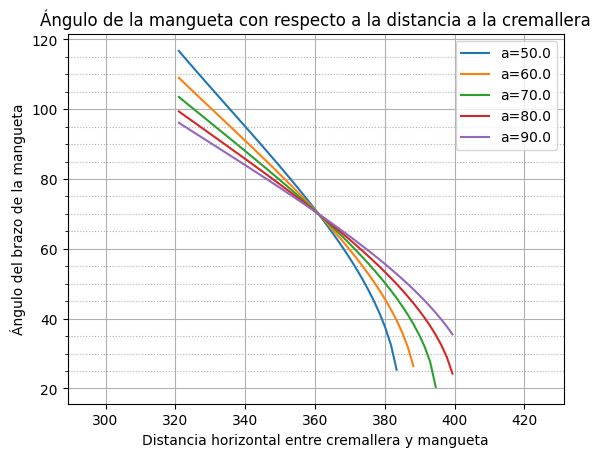

In [5]:
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

plt.title('Ángulo de la mangueta con respecto a la distancia a la cremallera')
plt.axis('equal')
plt.ylabel('Ángulo del brazo de la mangueta')
plt.xlabel('Distancia horizontal entre cremallera y mangueta')

legends = []

# plt.plot([MIN_DIR_DISTANCE, MAX_DIR_DISTANCE], [0,0], color='black')

for i in range(N_TESTS):
	plt.plot(rack_distance[i], assembly_angle[i]*RAD_TO_DEG)
	if len(tests[i][0]) == 0:
		legends.append(f'h={tests[i][-1]:0.2f}')
	else:
		legends.append(tests[i][0])

MAJOR_TIC = 20
MINOR_TIC = 5

maj_pos = ticker.MultipleLocator(MAJOR_TIC)
min_pos = ticker.MultipleLocator(MINOR_TIC)

# ax.xaxis.set(major_locator=maj_pos, minor_locator=min_pos)
ax.yaxis.set(major_locator=maj_pos, minor_locator=min_pos)
ax.grid(which='minor', linestyle=':')

plt.legend(legends)
plt.grid(True)
plt.show()

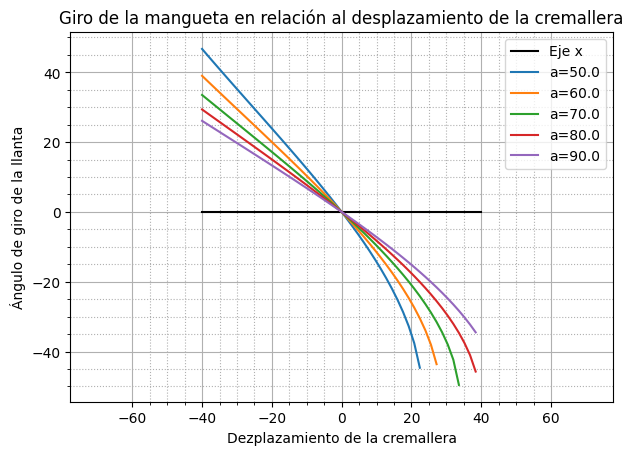

In [6]:
fig = plt.figure(figsize=(7.0, 4.8))
ax  = fig.add_subplot(1, 1, 1)

plt.title('Giro de la mangueta en relación al desplazamiento de la cremallera')
plt.axis('equal')
plt.ylabel('Ángulo de giro de la llanta')
plt.xlabel('Dezplazamiento de la cremallera')

legends = []

plt.plot([-DIR_DISPLACEMENT, DIR_DISPLACEMENT], [0,0], color='black')
legends.append('Eje x')

for i in range(N_TESTS):
	plt.plot(displacement[i], steering_angle[i]*RAD_TO_DEG)
	if len(tests[i][LABLE]) == 0:
		legends.append(f'h={tests[i][H]:0.2f}')
	else:
		legends.append(tests[i][LABLE])

maj_pos = ticker.MultipleLocator(MAJOR_TIC)
min_pos = ticker.MultipleLocator(MINOR_TIC)

ax.xaxis.set(major_locator=maj_pos, minor_locator=min_pos)
ax.yaxis.set(major_locator=maj_pos, minor_locator=min_pos)
ax.grid(which='minor', linestyle=':')

plt.legend(legends)
plt.grid(True)
plt.show()

In [7]:
for i in range(N_TESTS):
	max_idx = np.argmax(steering_angle[i])
	min_idx = np.argmin(steering_angle[i])

	if max_idx == min_idx:
		fail_idx = max_idx
		max_idx = np.argmax(steering_angle[i][:fail_idx])
		min_idx = np.argmin(steering_angle[i][:fail_idx])

	print(f'Experiment {i+1}')
	print(f'   Initial steering angle: {tetha0[i]*RAD_TO_DEG:.2f}°')
	
	print('   Dimentions:')
	print(f'       A: {tests[i][A]:.2f}mm')
	print(f'       B: {tests[i][B]:.2f}mm')
	
	print(f'   minimum steering angle: {steering_angle[i][min_idx]*RAD_TO_DEG:.2f}°', end=' ')
	print(f'displacement: {displacement[i][min_idx]:.2f}mm')

	print(f'   maximum steering angle: {steering_angle[i][max_idx]*RAD_TO_DEG:.2f}°', end=' ')
	print(f'displacement: {displacement[i][max_idx]:.2f}mm')
	print()

Experiment 1
   Initial steering angle: 70.00°
   Dimentions:
       A: 50.00mm
       B: 349.62mm
   minimum steering angle: -44.65° displacement: 22.40mm
   maximum steering angle: 46.70° displacement: -40.00mm

Experiment 2
   Initial steering angle: 70.00°
   Dimentions:
       A: 60.00mm
       B: 344.67mm
   minimum steering angle: -43.62° displacement: 27.20mm
   maximum steering angle: 39.00° displacement: -40.00mm

Experiment 3
   Initial steering angle: 70.00°
   Dimentions:
       A: 70.00mm
       B: 339.95mm
   minimum steering angle: -49.58° displacement: 33.60mm
   maximum steering angle: 33.51° displacement: -40.00mm

Experiment 4
   Initial steering angle: 70.00°
   Dimentions:
       A: 80.00mm
       B: 335.45mm
   minimum steering angle: -45.75° displacement: 38.40mm
   maximum steering angle: 29.36° displacement: -40.00mm

Experiment 5
   Initial steering angle: 70.00°
   Dimentions:
       A: 90.00mm
       B: 331.20mm
   minimum steering angle: -34.51° displaceme

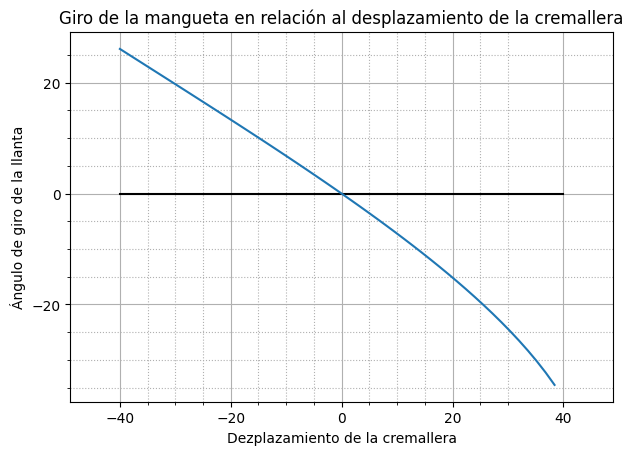

Initial steering angle: 70.00°
Dimentions:
       A: 90.00mm
       B: 331.20mm
       H: 110.00mm
minimum steering angle: -34.51° displacement: 38.40mm
maximum steering angle: 26.10° displacement: -40.00mm



In [9]:
a          = 90.0
selected_h = 110.0
selected_b = get_b_length(a, selected_h)

x, y = get_steering_curve(
	N_STEPS,
	MIN_DIR_DISTANCE, MAX_DIR_DISTANCE,
	a, selected_b,
	110.0
)

x -= MIDDLE_DIR_DISTANCE
# x *= TRAVEL_TO_DEG
y *= RAD_TO_DEG
y -= 70.0

fig = plt.figure(figsize=(7.0, 4.8))
ax  = fig.add_subplot(1, 1, 1)

plt.title('Giro de la mangueta en relación al desplazamiento de la cremallera')
plt.axis('equal')
plt.ylabel('Ángulo de giro de la llanta')
plt.xlabel('Dezplazamiento de la cremallera')

plt.plot([-DIR_DISPLACEMENT, DIR_DISPLACEMENT], [0,0], color='black')
plt.plot(x, y)

maj_pos = ticker.MultipleLocator(MAJOR_TIC)
min_pos = ticker.MultipleLocator(MINOR_TIC)

ax.xaxis.set(major_locator=maj_pos, minor_locator=min_pos)
ax.yaxis.set(major_locator=maj_pos, minor_locator=min_pos)
ax.grid(which='minor', linestyle=':')

plt.grid(True)
plt.show()

max_idx = np.argmax(y)
min_idx = np.argmin(y)

if max_idx == min_idx:
	fail_idx = max_idx
	max_idx = np.argmax(y[:fail_idx])
	min_idx = np.argmin(y[:fail_idx])

theta0 = dir_angle(a, selected_b, selected_h, MIDDLE_DIR_DISTANCE)*RAD_TO_DEG

print(f'Initial steering angle: {theta0:.2f}°')

print('Dimentions:')
print(f'       A: {a:.2f}mm')
print(f'       B: {selected_b:.2f}mm')
print(f'       H: {selected_h:.2f}mm')

print(f'minimum steering angle: {y[min_idx]:.2f}°', end=' ')
print(f'displacement: {x[min_idx]:.2f}mm')

print(f'maximum steering angle: {y[max_idx]:.2f}°', end=' ')
print(f'displacement: {x[max_idx]:.2f}mm')
print()